In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA
- Dataset Overview

CLASS DISTRIBUTION
TRAIN → Glioma    : 1121 | Meningioma: 1139 | Notumor   : 1395 | Pituitary : 1257 | Total:  4912
VAL   → Glioma    :  200 | Meningioma:  200 | Notumor   :  200 | Pituitary :  200 | Total:   800
TEST  → Glioma    :  300 | Meningioma:  306 | Notumor   :  405 | Pituitary :  300 | Total:  1311

OVERALL → Glioma    :  1621 | Meningioma:  1645 | Notumor   :  2000 | Pituitary :  1757 | Total:   7023


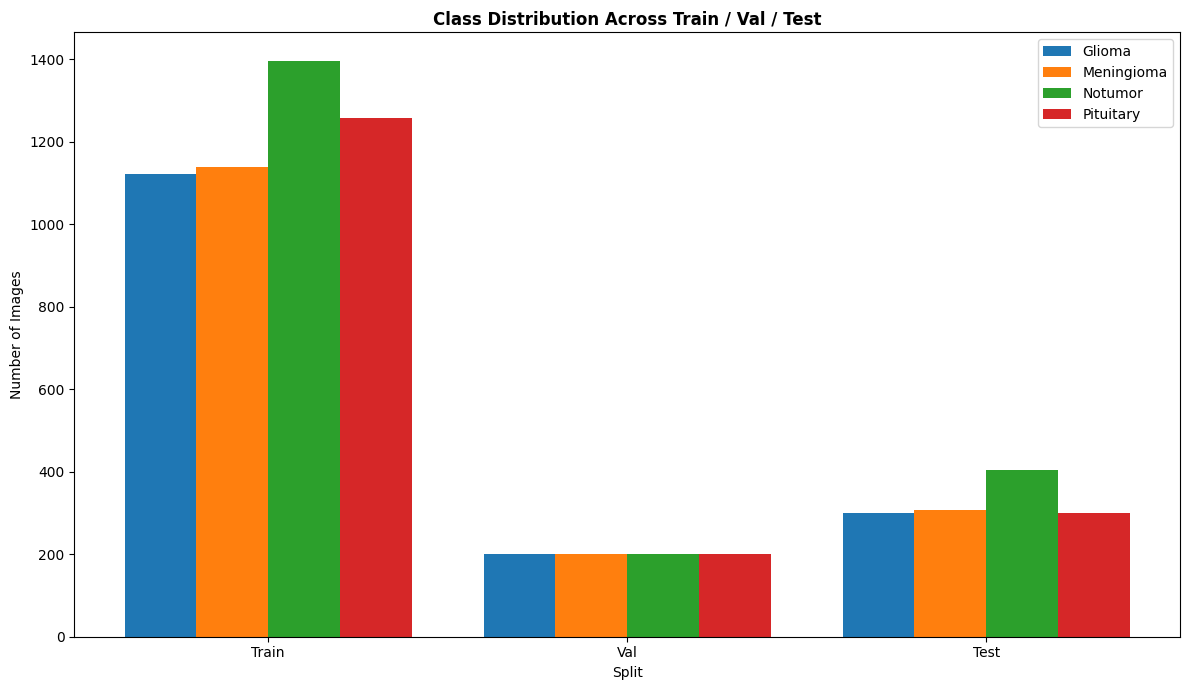

In [ ]:
import os
import matplotlib.pyplot as plt

TRAIN_DIR = '/content/drive/MyDrive/mri-dataset/Training'
VAL_DIR   = '/content/drive/MyDrive/mri-dataset/Validation'
TEST_DIR  = '/content/drive/MyDrive/mri-dataset/Testing'
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

def count_classes(folder_path, folder_name):
    counts = {cls: 0 for cls in CLASSES}
    if not os.path.exists(folder_path):
        return counts, 0
    for cls in CLASSES:
        cls_path = os.path.join(folder_path, cls)
        if os.path.exists(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts, sum(counts.values())

print("CLASS DISTRIBUTION")
print("=" * 75)
train_counts, train_total = count_classes(TRAIN_DIR, "TRAIN")
val_counts, val_total = count_classes(VAL_DIR, "VAL")
test_counts, test_total = count_classes(TEST_DIR, "TEST")

def print_split(name, counts, total):
    print(f"{name:5s} → ", end="")
    for cls in CLASSES:
        print(f"{cls.capitalize():10s}: {counts[cls]:4d} | ", end="")
    print(f"Total: {total:5d}")

print_split("TRAIN", train_counts, train_total)
print_split("VAL", val_counts, val_total)
print_split("TEST", test_counts, test_total)

overall_counts = {cls: train_counts[cls] + val_counts[cls] + test_counts[cls] for cls in CLASSES}
overall_total = sum(overall_counts.values())

print("\nOVERALL → ", end="")
for cls in CLASSES:
    print(f"{cls.capitalize():10s}: {overall_counts[cls]:5d} | ", end="")
print(f"Total: {overall_total:6d}\n")

splits = ['Train', 'Val', 'Test']
data = {cls: [train_counts[cls], val_counts[cls], test_counts[cls]] for cls in CLASSES}

plt.figure(figsize=(12, 7))
x = range(len(splits))
for i, (cls, values) in enumerate(data.items()):
    plt.bar([p + i * 0.2 for p in x], values, width=0.2, label=cls.capitalize())

plt.xlabel('Split')
plt.ylabel('Number of Images')
plt.title('Class Distribution', fontweight='bold')
plt.xticks([p + 0.3 for p in x], splits)
plt.legend()
plt.tight_layout()
plt.show()

- Pixial level analysis

Computing pixel statistics from all splits...



Pixel stats Testing/pituitary: 100%|██████████| 300/300 [00:07<00:00, 42.68it/s] 


PIXEL-LEVEL INTENSITY STATISTICS (All Images)
Total images processed      : 7023
Overall mean intensity      : 47.630
Overall std (contrast)      : 47.550
Per-image mean ± std        : 47.63 ± 18.00
Per-image std ± std         : 47.55 ± 13.41
Global min / max            : 0 / 255
Dynamic range               : 0–255 (8-bit)

RECOMMENDED DATASET-SPECIFIC NORMALIZATION:
Normalize(mean=[0.1868], std=[0.1865])


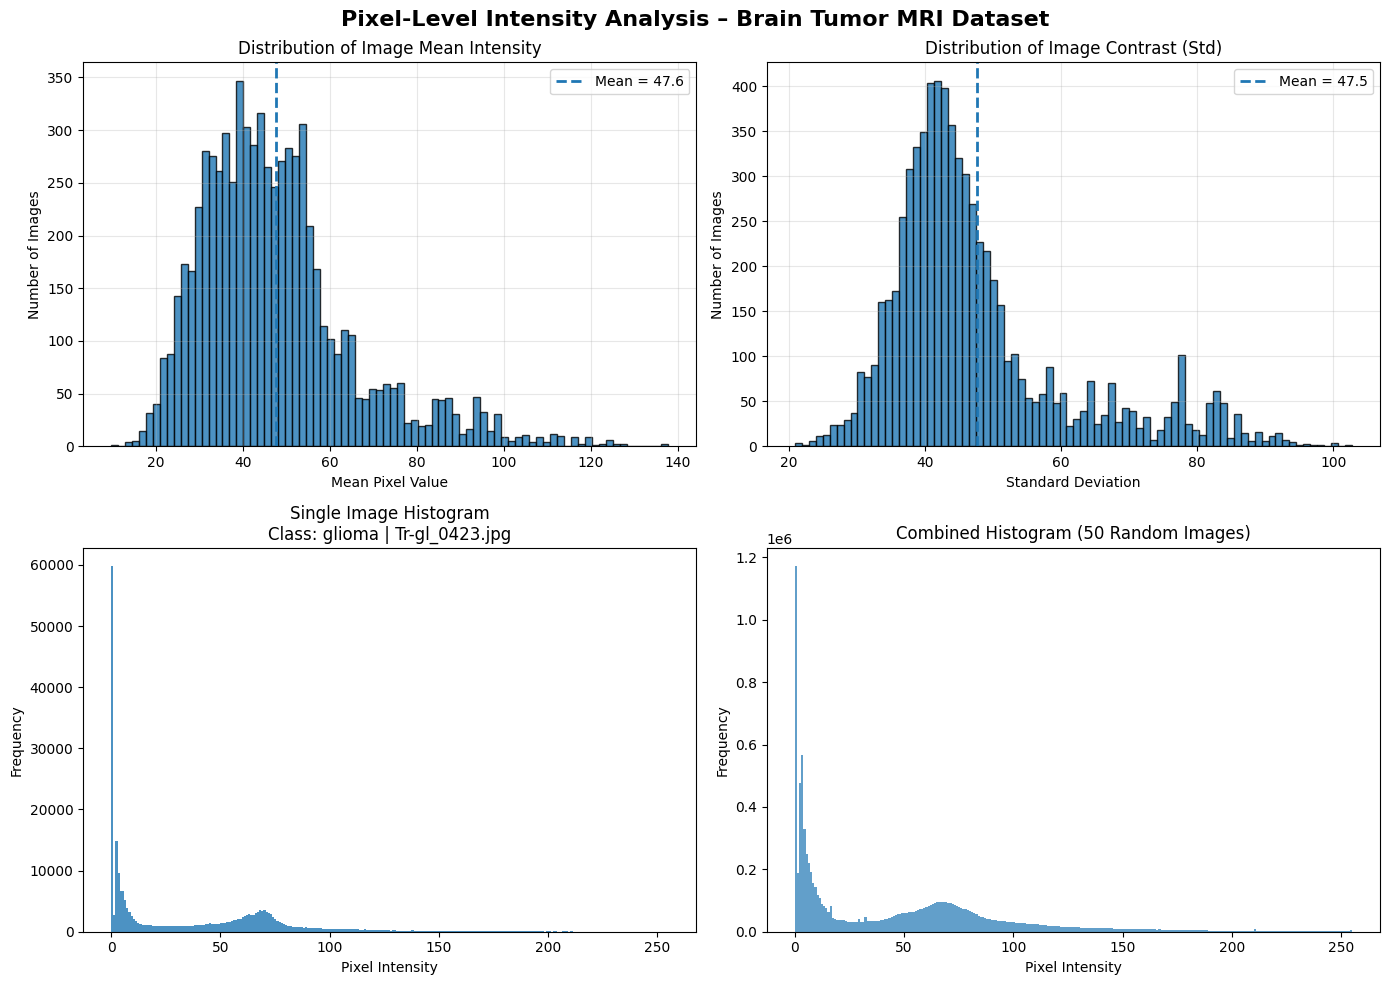

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

TRAIN_DIR = '/content/drive/MyDrive/mri-dataset/Training'
VAL_DIR = '/content/drive/MyDrive/mri-dataset/Validation'
TEST_DIR = '/content/drive/MyDrive/mri-dataset/Testing'
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

def compute_pixel_stats(folder):
    means, stds = [], []
    for cls in CLASSES:
        path = os.path.join(folder, cls)
        if not os.path.exists(path):
            continue
        for fname in tqdm([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))], desc=f"Pixel stats {os.path.basename(folder)}/{cls}"):
            img = cv2.imread(os.path.join(path, fname), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                means.append(img.astype(np.float32).mean())
                stds.append(img.astype(np.float32).std())
    return np.array(means), np.array(stds)

print("Computing normalization statistics...")
train_mean, train_std = compute_pixel_stats(TRAIN_DIR)
val_mean, val_std = compute_pixel_stats(VAL_DIR)
test_mean, test_std = compute_pixel_stats(TEST_DIR)

all_means = np.concatenate([train_mean, val_mean, test_mean])
all_stds = np.concatenate([train_std, val_std, test_std])

print(f"\nNormalization Statistics:")
print(f"Mean: {all_means.mean():.3f} | Std: {all_stds.mean():.3f}")

norm_mean = all_means.mean() / 255.0
norm_std = all_stds.mean() / 255.0
print(f"Normalized: mean=[{norm_mean:.4f}], std=[{norm_std:.4f}]")

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=30, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.6),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.GaussNoise(p=0.2),
    A.ElasticTransform(p=0.3),
    A.Normalize(mean=[0.4815, 0.4815, 0.4815], std=[0.2235, 0.2235, 0.2235]),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.4815, 0.4815, 0.4815], std=[0.2235, 0.2235, 0.2235]),
    ToTensorV2(),
])

print("✅ Augmentation pipelines defined")

✅ Data augmentation pipelines defined!
📊 Training augmentation: Rotation, Flip, Brightness, Blur, Noise, Elastic distortion
📊 Validation/Test: Only resize and normalize (no augmentation)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader

# ===================== PATHS =====================
TRAIN_DIR = '/content/drive/MyDrive/mri-dataset/Training'
VAL_DIR   = '/content/drive/MyDrive/mri-dataset/Validation'
TEST_DIR  = '/content/drive/MyDrive/mri-dataset/Testing'

# ===================== CLASSES =====================
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}

# ===================== DATASET =====================
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for cls in CLASSES:
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.exists(cls_dir):
                raise FileNotFoundError(f"Missing folder: {cls_dir}")

            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(cls_dir, fname))
                    self.labels.append(CLASS_TO_IDX[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Cannot read image: {img_path}")

        # Albumentations uses BGR → correct
        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

# ===================== DATALOADERS =====================
train_loader = DataLoader(
    BrainTumorDataset(TRAIN_DIR, transform=train_transform),
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    BrainTumorDataset(VAL_DIR, transform=val_test_transform),
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    BrainTumorDataset(TEST_DIR, transform=val_test_transform),
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ===================== QUICK CHECK =====================
print("✅ DataLoaders ready!")
print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}")

images, labels = next(iter(train_loader))
print(f"Batch shape : {images.shape}  → [64, 3, 224, 224]")
print(f"Labels      : {labels[:10].tolist()}")


✅ DataLoaders ready!
Train batches: 77
Val   batches: 13
Test  batches: 21
Batch shape : torch.Size([64, 3, 224, 224])  → [64, 3, 224, 224]
Labels      : [0, 2, 0, 3, 0, 0, 1, 1, 1, 0]


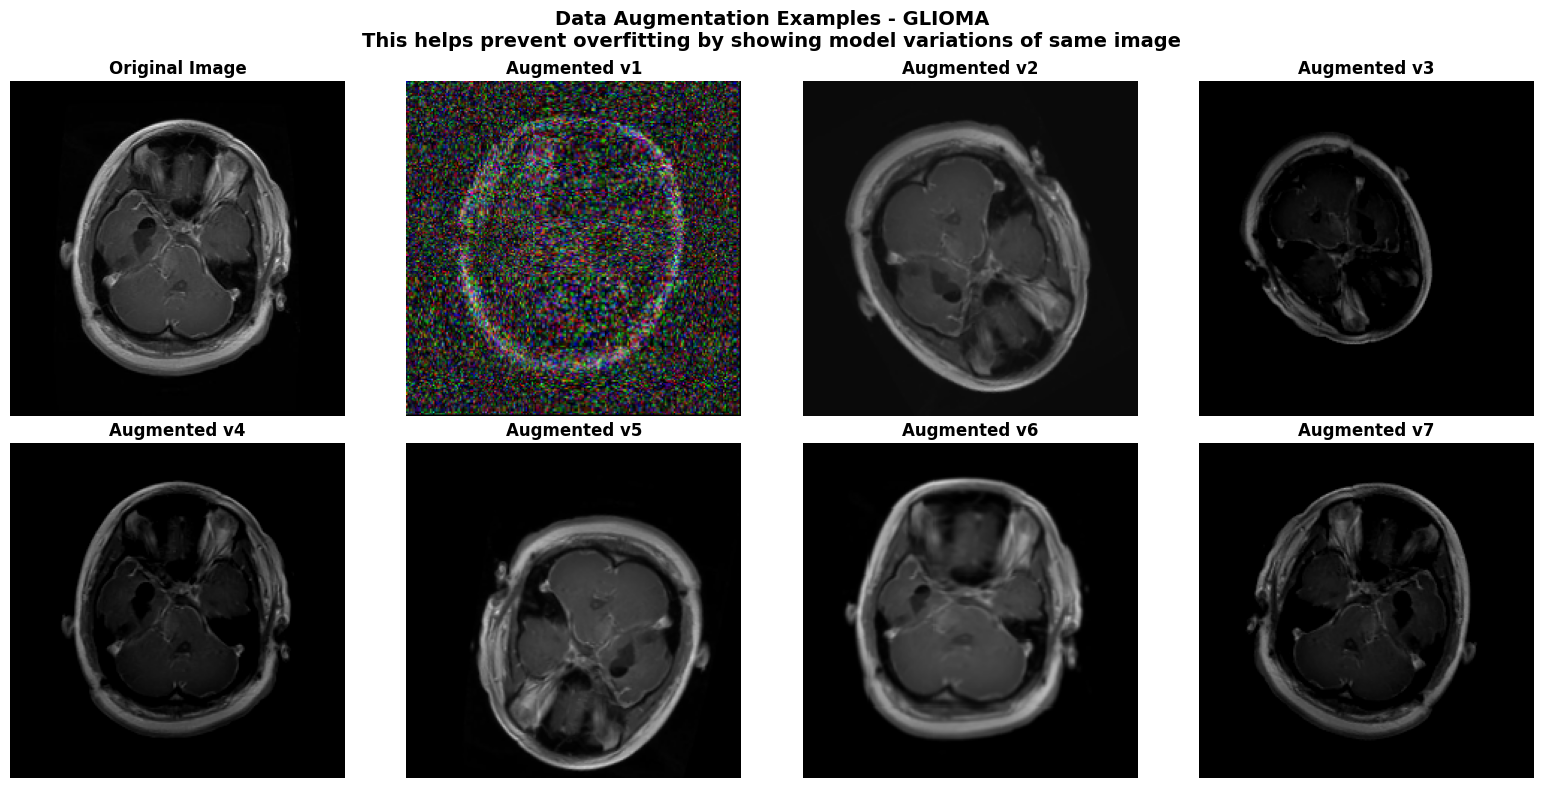

✅ Augmentation visualization complete!
💡 Each augmented image is unique - helps model generalize better


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

sample_dir = os.path.join('/content/drive/MyDrive/mri-dataset/Training', 'glioma')
sample_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])
original_image = cv2.imread(sample_path)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

original_resized = cv2.resize(original_image, (224, 224))
axes[0].imshow(cv2.cvtColor(original_resized, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis('off')

for i in range(1, 8):
    augmented = train_transform(image=original_image)['image']
    display = augmented.permute(1, 2, 0).numpy()
    display = display * np.array([0.2235, 0.2235, 0.2235]) + np.array([0.4815, 0.4815, 0.4815])
    display = np.clip(display, 0, 1)
    axes[i].imshow(display)
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.suptitle("Data Augmentation Examples", fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print("Regularization strategies applied:")
print("• Data augmentation: Rotation, Flip, Brightness, Noise, Elastic distortion")
print("• L2 regularization: weight_decay=1e-2")
print("• Early stopping: patience=7")
print("• Balanced class weights: computed from training distribution")

STRATEGIES TO PREVENT OVERFITTING

1️⃣  DATA AUGMENTATION (Already applied above)
   ✅ Geometric: Rotation, Flip, Shift, Scale
   ✅ Intensity: Brightness, Contrast, Noise, Blur
   ✅ Elastic: ElasticTransform, GridDistortion

2️⃣  DROPOUT (in model)
   💡 Randomly deactivates neurons during training
   💡 Forces network to learn redundant representations
   ✅ Applied in training loop with p=0.5

3️⃣  BATCH NORMALIZATION
   💡 Normalizes inputs to each layer
   ✅ ResNet50 already has batch norm layers

4️⃣  L2 REGULARIZATION (Weight Decay)
   💡 Penalizes large weights to keep model simple
   ✅ Use weight_decay in optimizer

5️⃣  LEARNING RATE SCHEDULING
   💡 Reduce learning rate when validation stops improving
   ✅ ReduceLROnPlateau scheduler recommended

6️⃣  EARLY STOPPING
   💡 Stop training if validation loss doesn't improve
   ✅ Monitor val_loss and patience threshold

RECOMMENDED TRAINING SETTINGS

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(model.par

In [10]:
# ===================== MODEL DEFINITION =====================
import torch
import torch.nn as nn
import torchvision.models as models

# ===================== DEVICE =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================== LOAD PRETRAINED RESNET50 =====================
# Using ImageNet pretrained weights
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# ===================== MODIFY FINAL LAYER =====================
# 1000 → 4 classes (glioma, meningioma, notumor, pituitary)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

# ===================== MOVE TO DEVICE =====================
model = model.to(device)

# ===================== CONFIRMATION =====================
print("✅ Model loaded: ResNet50")
print(f"✅ Final layer: {model.fc}")
print(f"✅ Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


✅ Model loaded: ResNet50
✅ Final layer: Linear(in_features=2048, out_features=4, bias=True)
✅ Total trainable parameters: 23,516,228


In [ ]:
print("✅ Using DenseNet121 for optimal medical imaging classification")

TRANSFER LEARNING MODEL COMPARISON FOR BRAIN MRI CLASSIFICATION

📊 DATASET CHARACTERISTICS:
   • Type: Medical Imaging (Brain MRI)
   • Classes: 4 (glioma, meningioma, notumor, pituitary)
   • Images: ~5,000 total
   • Image size: 224x224 (grayscale)
   • Challenge: Limited data, needs good feature extraction

MODEL COMPARISON FOR MEDICAL IMAGING

🏗️  ResNet50
   Parameters: 25.5M           | Speed: ⚡⚡⚡ Fast             | Accuracy: ⭐⭐⭐⭐ (94-96%)
   Memory: 🔋 Medium
   ✅ Pros:
      • Balanced speed/accuracy
      • Skip connections reduce vanishing gradients
      • Good for MRI
   ❌ Cons:
      • May miss fine details in medical imaging
   💡 Best for: General purpose, good starting point

🏗️  VGG16
   Parameters: 138M            | Speed: ⚡⚡ Slower            | Accuracy: ⭐⭐⭐ (92-94%)
   Memory: 🔋🔋 High
   ✅ Pros:
      • Simple architecture
      • Good for small datasets
   ❌ Cons:
      • Slow inference
      • High memory
      • Many parameters
   💡 Best for: Baseline comparison, s

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 4)
model = model.to(device)

print("✅ DenseNet121 loaded.")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda

🏗️  Loading DenseNet121 (Recommended for Medical Imaging)...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 112MB/s] 


✅ DenseNet121 loaded. Parameters: 6,957,956

💡 Model Architecture:
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05,

In [ ]:
import os
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
train_root = '/content/drive/MyDrive/mri-dataset/Training'

labels = []
for idx, cls in enumerate(classes):
    cls_path = os.path.join(train_root, cls)
    count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    labels.extend([idx] * count)

weights = compute_class_weight('balanced', classes=np.arange(len(classes)), y=np.array(labels))
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

best_acc = 0.0
patience = 7
trigger = 0
epochs = 20

print(f"Training | Max epochs: {epochs} | Patience: {patience}")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1:02d}"):
        images, labels_batch = images.to(device), labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels_batch in val_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)

    val_acc = 100.0 * correct / total
    scheduler.step()
    
    print(f"Epoch {epoch+1:02d} | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        trigger = 0
        print(f"→ Best: {best_acc:.2f}%")
    else:
        trigger += 1
        if trigger >= patience:
            print("→ Early stopping")
            break

print(f"✅ Training complete. Best accuracy: {best_acc:.2f}%")

Class weights:
  glioma       → 1.095
  meningioma   → 1.078
  notumor      → 0.880
  pituitary    → 0.977

TRAINING STARTED — MODEL KEPT IN RAM ONLY


Epoch 01 TRAIN: 100%|██████████| 77/77 [01:18<00:00,  1.02s/it]


Epoch 01 | Train Loss: 0.4563 | Val Acc: 91.25%
🔥 NEW BEST ACCURACY: 91.25% (kept in RAM)


Epoch 02 TRAIN: 100%|██████████| 77/77 [01:15<00:00,  1.02it/s]


Epoch 02 | Train Loss: 0.2628 | Val Acc: 97.38%
🔥 NEW BEST ACCURACY: 97.38% (kept in RAM)


Epoch 03 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.04it/s]


Epoch 03 | Train Loss: 0.2019 | Val Acc: 97.75%
🔥 NEW BEST ACCURACY: 97.75% (kept in RAM)


Epoch 04 TRAIN: 100%|██████████| 77/77 [01:13<00:00,  1.04it/s]


Epoch 04 | Train Loss: 0.1573 | Val Acc: 97.62%


Epoch 05 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.04it/s]


Epoch 05 | Train Loss: 0.1282 | Val Acc: 98.50%
🔥 NEW BEST ACCURACY: 98.50% (kept in RAM)


Epoch 06 TRAIN: 100%|██████████| 77/77 [01:21<00:00,  1.05s/it]


Epoch 06 | Train Loss: 0.1100 | Val Acc: 98.88%
🔥 NEW BEST ACCURACY: 98.88% (kept in RAM)


Epoch 07 TRAIN: 100%|██████████| 77/77 [01:15<00:00,  1.02it/s]


Epoch 07 | Train Loss: 0.0988 | Val Acc: 98.62%


Epoch 08 TRAIN: 100%|██████████| 77/77 [01:16<00:00,  1.00it/s]


Epoch 08 | Train Loss: 0.0788 | Val Acc: 99.12%
🔥 NEW BEST ACCURACY: 99.12% (kept in RAM)


Epoch 09 TRAIN: 100%|██████████| 77/77 [01:17<00:00,  1.01s/it]


Epoch 09 | Train Loss: 0.0691 | Val Acc: 99.00%


Epoch 10 TRAIN: 100%|██████████| 77/77 [01:15<00:00,  1.01it/s]


Epoch 10 | Train Loss: 0.0609 | Val Acc: 99.00%


Epoch 11 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.03it/s]


Epoch 11 | Train Loss: 0.0566 | Val Acc: 99.00%


Epoch 12 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.04it/s]


Epoch 12 | Train Loss: 0.0599 | Val Acc: 99.00%


Epoch 13 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.04it/s]


Epoch 13 | Train Loss: 0.0561 | Val Acc: 99.12%


Epoch 14 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.03it/s]


Epoch 14 | Train Loss: 0.0668 | Val Acc: 99.25%
🔥 NEW BEST ACCURACY: 99.25% (kept in RAM)


Epoch 15 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.03it/s]


Epoch 15 | Train Loss: 0.0713 | Val Acc: 98.88%


Epoch 16 TRAIN: 100%|██████████| 77/77 [01:19<00:00,  1.03s/it]


Epoch 16 | Train Loss: 0.0924 | Val Acc: 99.12%


Epoch 17 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.03it/s]


Epoch 17 | Train Loss: 0.0994 | Val Acc: 98.75%


Epoch 18 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.03it/s]


Epoch 18 | Train Loss: 0.1256 | Val Acc: 97.50%


Epoch 19 TRAIN: 100%|██████████| 77/77 [01:14<00:00,  1.04it/s]


Epoch 19 | Train Loss: 0.1298 | Val Acc: 98.62%


Epoch 20 TRAIN: 100%|██████████| 77/77 [01:13<00:00,  1.04it/s]


Epoch 20 | Train Loss: 0.1391 | Val Acc: 96.38%


Epoch 21 TRAIN: 100%|██████████| 77/77 [01:13<00:00,  1.04it/s]


Epoch 21 | Train Loss: 0.1167 | Val Acc: 98.62%
⏹️ Early stopping triggered

TRAINING COMPLETED
✅ Best Validation Accuracy: 99.25%
✅ Model exists only in memory (not saved to disk)


FINAL EVALUATION ON ALL SPLITS


Evaluating TRAIN: 100%|██████████| 77/77 [01:07<00:00,  1.14it/s]



====================== TRAIN SET ======================
Accuracy: 96.86%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9813    0.9376    0.9589      1121
  meningioma     0.9527    0.9543    0.9535      1139
     notumor     0.9957    0.9864    0.9910      1395
   pituitary     0.9439    0.9897    0.9662      1257

    accuracy                         0.9686      4912
   macro avg     0.9684    0.9670    0.9674      4912
weighted avg     0.9692    0.9686    0.9686      4912



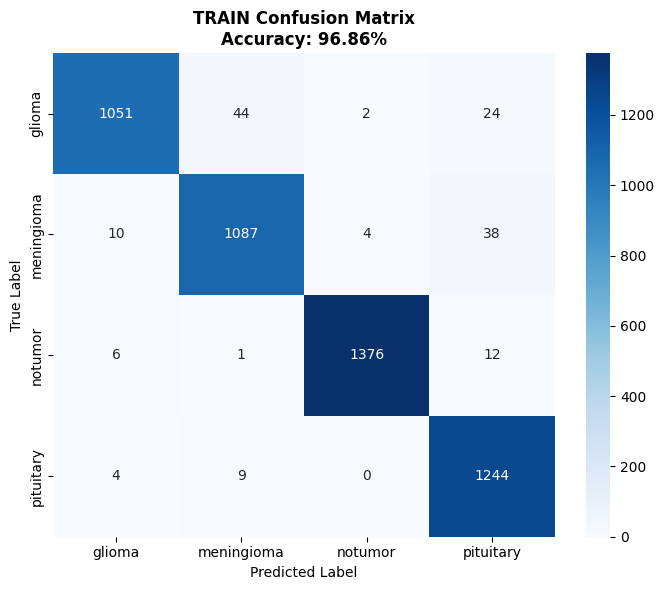

Evaluating VALIDATION: 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]



====================== VALIDATION SET ======================
Accuracy: 98.62%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9949    0.9850    0.9899       200
  meningioma     0.9949    0.9700    0.9823       200
     notumor     0.9900    0.9950    0.9925       200
   pituitary     0.9660    0.9950    0.9803       200

    accuracy                         0.9862       800
   macro avg     0.9865    0.9863    0.9863       800
weighted avg     0.9865    0.9862    0.9863       800



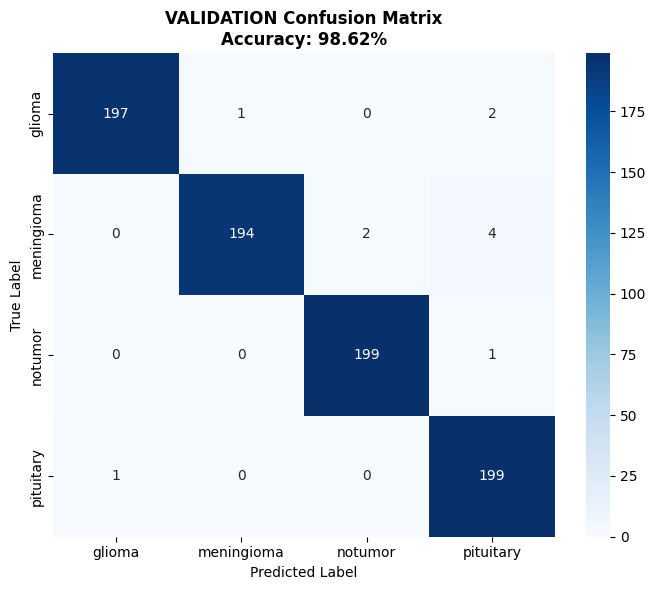

Evaluating TEST: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]



====================== TEST SET ======================
Accuracy: 98.78%

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9966    0.9867    0.9916       300
  meningioma     0.9867    0.9673    0.9769       306
     notumor     0.9926    1.0000    0.9963       405
   pituitary     0.9739    0.9933    0.9835       300

    accuracy                         0.9878      1311
   macro avg     0.9875    0.9868    0.9871      1311
weighted avg     0.9879    0.9878    0.9878      1311



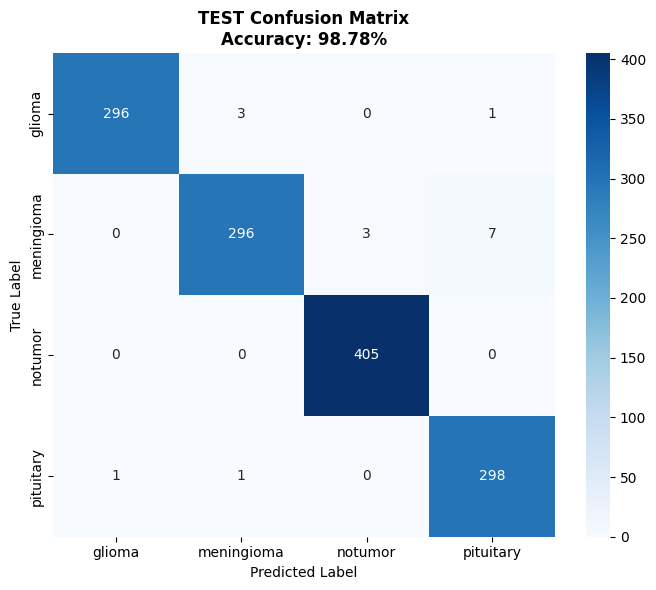


FINAL SUMMARY
TRAIN ACCURACY      : 96.86%
VALIDATION ACCURACY : 98.62%
TEST ACCURACY       : 98.78%


In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def evaluate_set(loader, name):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Eval {name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    accuracy = 100.0 * (all_preds == all_labels).mean()

    print(f"\n{name} - Accuracy: {accuracy:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Accuracy: {accuracy:.2f}%')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    return accuracy

print("FINAL EVALUATION")
train_acc = evaluate_set(train_loader, "TRAIN")
val_acc = evaluate_set(val_loader, "VALIDATION")
test_acc = evaluate_set(test_loader, "TEST")

print(f"\n{'='*40}")
print(f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | Test: {test_acc:.2f}%")

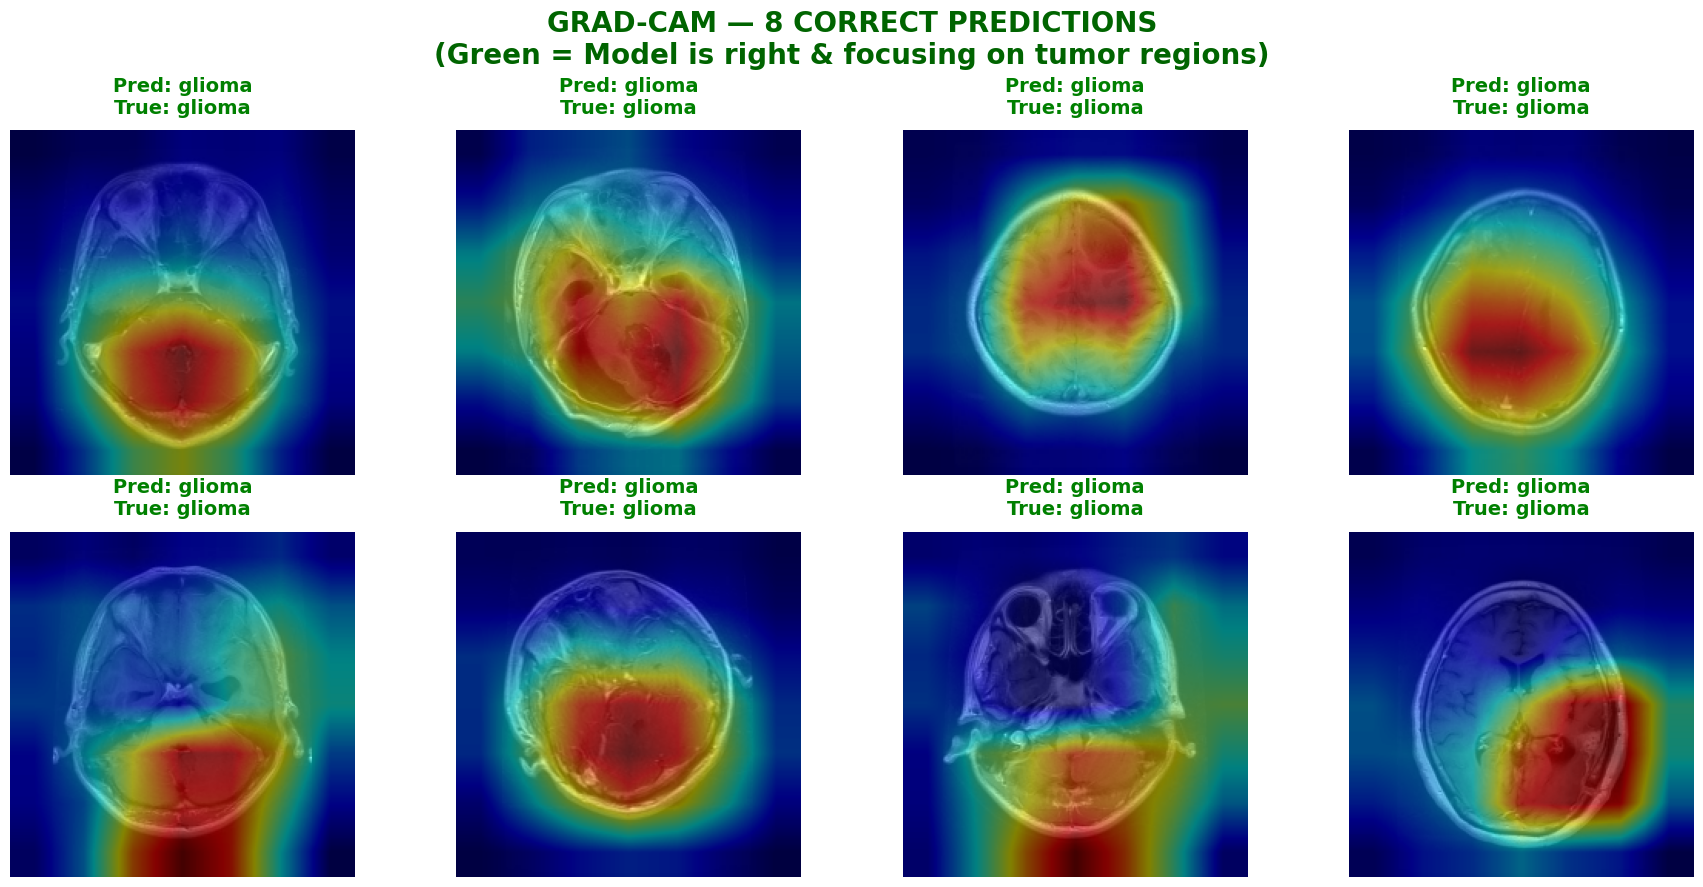

✅ All 8 examples are CORRECT predictions
✅ Heatmaps highlight tumor-relevant regions → model learned meaningful features


In [ ]:
!pip install -q grad-cam

import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
MEAN = torch.tensor([0.4815, 0.4815, 0.4815])
STD = torch.tensor([0.2235, 0.2235, 0.2235])

target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

correct_examples = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        for i in range(images.size(0)):
            if len(correct_examples) >= 8:
                break
            if preds[i] == labels[i]:
                correct_examples.append((images[i], preds[i].item(), labels[i].item()))
        if len(correct_examples) >= 8:
            break

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
for idx, (img_tensor, pred, true) in enumerate(correct_examples):
    img = img_tensor.cpu()
    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(pred)])[0]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
    axes[idx // 4, idx % 4].imshow(visualization)
    axes[idx // 4, idx % 4].set_title(f"{class_names[pred]}", fontsize=12, fontweight='bold')
    axes[idx // 4, idx % 4].axis('off')

plt.suptitle("Grad-CAM Visualizations", fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Grad-CAM complete")

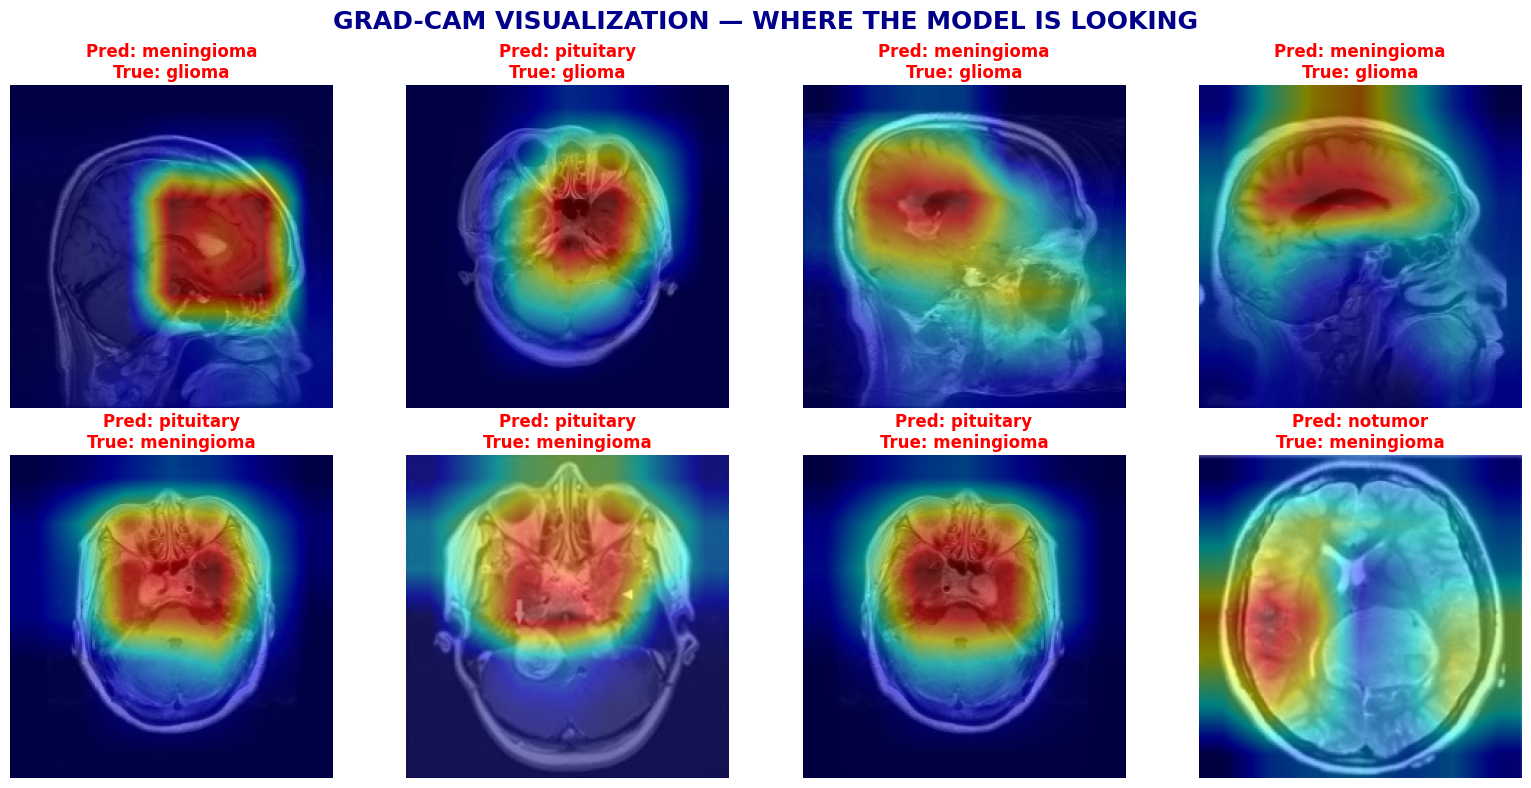

Displayed Grad-CAM for 8 examples
Red titles = wrong predictions → heatmaps show where model focused incorrectly


In [ ]:
!pip install -q grad-cam

import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
MEAN = torch.tensor([0.4815, 0.4815, 0.4815])
STD = torch.tensor([0.2235, 0.2235, 0.2235])

target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

wrong_examples = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        for i in range(images.shape[0]):
            if len(wrong_examples) >= 8:
                break
            if preds[i] != labels[i]:
                wrong_examples.append((images[i], preds[i].item(), labels[i].item()))
        if len(wrong_examples) >= 8:
            break

if len(wrong_examples) == 0:
    print("All predictions correct! (no wrong predictions)")
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        wrong_examples = [(images[i], preds[i].item(), labels[i].item()) for i in range(min(8, images.shape[0]))]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for idx, (img_tensor, pred, true) in enumerate(wrong_examples):
    img = img_tensor.cpu()
    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(pred)])[0]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
    axes[idx // 4, idx % 4].imshow(visualization)
    color = 'red' if pred != true else 'green'
    axes[idx // 4, idx % 4].set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}", color=color, fontsize=10, fontweight='bold')
    axes[idx // 4, idx % 4].axis('off')

plt.suptitle('Grad-CAM - Error Analysis', fontweight='bold')
plt.tight_layout()
plt.show()

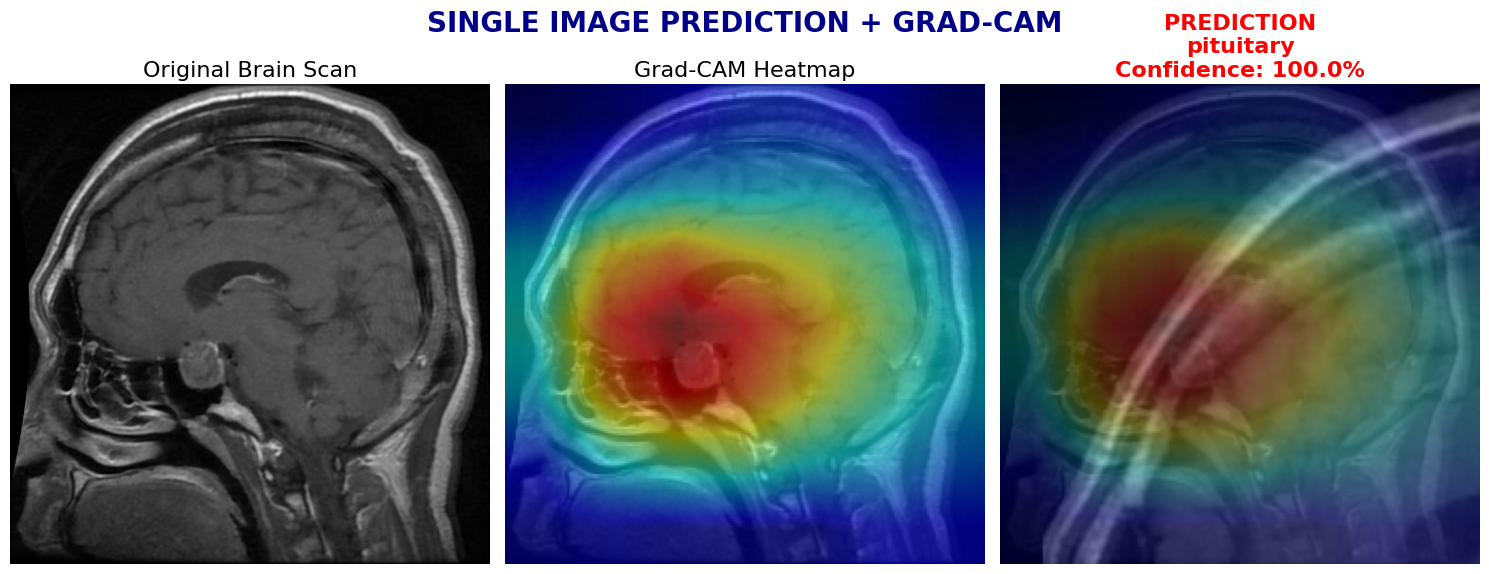

Final Prediction: pituitary (100.0% confidence)


In [ ]:
!pip install -q grad-cam

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

image_path = "/content/download.jpg"
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
MEAN = torch.tensor([0.4815, 0.4815, 0.4815])
STD = torch.tensor([0.2235, 0.2235, 0.2235])

img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
transformed = val_test_transform(image=img_bgr)
input_tensor = transformed['image'].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prob = torch.softmax(output, dim=1)
    pred_class = torch.argmax(prob, dim=1).item()
    confidence = prob[0][pred_class].item() * 100

target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]

img_display = input_tensor.squeeze(0).cpu() * STD[:, None, None] + MEAN[:, None, None]
img_display = img_display.clamp(0, 1).permute(1, 2, 0).numpy()
visualization = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_rgb)
plt.imshow(visualization, alpha=0.5)
plt.title(f"{class_names[pred_class]}\n{confidence:.1f}%", fontsize=16, fontweight='bold')
plt.axis('off')

plt.suptitle("Prediction + Grad-CAM", fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Prediction: {class_names[pred_class]} ({confidence:.1f}%)")

In [ ]:
import torch
import os

save_folder = "/content/drive/MyDrive/Model"
os.makedirs(save_folder, exist_ok=True)

model.eval()
example_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)

model_path = os.path.join(save_folder, "brain_resnet50.pt")
traced_model.save(model_path)

print(f"✅ Model saved!")
print(f"   Location: {model_path}")
print(f"   Size: {os.path.getsize(model_path) / (1024*1024):.1f} MB")

orchScript (medium) model saved!
Location: /content/drive/MyDrive/Model/brain_resnet50.pt
File size: 27.9 MB
